## Importing required libraries

In [1]:
from tqdm import tqdm
import logging
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split


from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import GloVe, vocab
from torchtext.datasets import AG_NEWS
from torchtext.data.functional import to_map_style_dataset


from torchdata.datapipes.iter import IterableWrapper, Mapper

from gensim.models import Word2Vec

import seaborn as sns
from sklearn.manifold import TSNE
from IPython.core.display import display, SVG

%matplotlib inline

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

C:\Users\vijay\AppData\Local\Temp\ipykernel_18256\2207896738.py:29: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, SVG


#### Checking if CUDA is available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


#### Defing a funtion to plot word embeddings in 2d space

In [3]:
def plot_embeddings(word_embeddings, vocab=vocab):

    # performing t-SNE on the embeddings to reduce their dimentionality to 2D using "TSNE" function from "sklearn" libary
    tsne = TSNE(n_components=2, random_state=0)
    word_embeddings_2d = tsne.fit_transform(word_embeddings)

    # plotting the results with labels from vocab
    plt.figure(figsize=(15,15))
    for i, word in enumerate(vocab.get_itos()):
        plt.scatter(word_embeddings_2d[i,0], word_embeddings_2d[i,1])
        plt.annotate(word, (word_embeddings_2d[i,0], word_embeddings_2d[i,1]))

    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.title("Word Embeddings visualized with t-SNE")
    plt.show()

#### Defining a function to return similar words to a given word by calculating Cosine distance~

In [4]:
def find_similar_word(word, word_embeddings, top_k=5):
    if word not in word_embeddings:
        print("Word not found in embeddings.")
        return []

    target_embedding = word_embeddings[word]

    # calculating cosine distange with all words
    similarities = {}
    for w, embedding in word_embeddings.items():
        if w != word:
            similarity = torch.dot(target_embedding, embedding) / (torch.norm(traget_embedding) * torch.norm(embedding))
            similarities[w] = similarity.item()

    # soting the similarities
    sorted_similarities = sorted(similarities.items(), key= lambda x: x[1], reverse=True)

    # returning the tok k similar words
    most_similar_word = [w for w, _ in sorted_similarities[:tok_k]]
    return most_similar_words

#### A toy dataset

In [5]:
toy_data = """I wish I was little bit taller
I wish I was a baller
She wore a small black dress to the party
The dog chased a big red ball in the park
He had a huge smile on his face when he won the race
The tiny kitten played with a fluffy toy mouse
The team celebrated their victory with a grand parade
She bought a small, delicate necklace for her sister
The mountain peak stood majestic and tall against the clear blue sky
The toddler took small, careful steps as she learned to walk
The house had a spacious backyard with a big swimming pool
He felt a sense of accomplishment after completing the challenging puzzle
The chef prepared a delicious, flavorful dish using fresh ingredients
The children played happily in the small, cozy room
The book had an enormous impact on readers around the world
The wind blew gently, rustling the leaves of the tall trees
She painted a beautiful, intricate design on the small canvas
The concert hall was filled with thousands of excited fans
The garden was adorned with colorful flowers of all sizes
I hope to achieve great success in my chosen career path
The skyscraper towered above the city, casting a long shadow
He gazed in awe at the breathtaking view from the mountaintop
The artist created a stunning masterpiece with bold brushstrokes
The baby took her first steps, a small milestone that brought joy to her parents
The team put in a tremendous amount of effort to win the championship
The sun set behind the horizon, painting the sky in vibrant colors
The professor gave a fascinating lecture on the history of ancient civilizations
The house was filled with laughter and the sound of children playing
She received a warm, enthusiastic welcome from the audience
The marathon runner had incredible endurance and determination
The child's eyes sparkled with excitement upon opening the gift
The ship sailed across the vast ocean, guided by the stars
The company achieved remarkable growth in a short period of time
The team worked together harmoniously to complete the project
The puppy wagged its tail, expressing its happiness and affection
She wore a stunning gown that made her feel like a princess
The building had a grand entrance with towering columns
The concert was a roaring success, with the crowd cheering and clapping
The baby took a tiny bite of the sweet, juicy fruit
The athlete broke a new record, achieving a significant milestone in her career
The sculpture was a masterpiece of intricate details and craftsmanship
The forest was filled with towering trees, creating a sense of serenity
The children built a small sandcastle on the beach, their imaginations running wild
The mountain range stretched as far as the eye could see, majestic and awe-inspiring
The artist's brush glided smoothly across the canvas, creating a beautiful painting
She received a small token of appreciation for her hard work and dedication
The orchestra played a magnificent symphony that moved the audience to tears
The flower bloomed in vibrant colors, attracting butterflies and bees
The team celebrated their victory with a big, extravagant party
The child's laughter echoed through the small room, filling it with joy
The sunflower stood tall, reaching for the sky with its bright yellow petals
The city skyline was dominated by tall buildings and skyscrapers
The cake was adorned with a beautiful, elaborate design for the special occasion
The storm brought heavy rain and strong winds, causing widespread damage
The small boat sailed peacefully on the calm, glassy lake
The artist used bold strokes of color to create a striking and vivid painting
The couple shared a passionate kiss under the starry night sky
The mountain climber reached the summit after a long and arduous journey
The child's eyes widened in amazement as the magician performed his tricks
The garden was filled with the sweet fragrance of blooming flowers
The basketball player made a big jump and scored a spectacular slam dunk
The cat pounced on a small mouse, displaying its hunting instincts
The mansion had a grand entrance with a sweeping staircase and chandeliers
The raindrops fell gently, creating a rhythmic patter on the roof
The baby took a big step forward, encouraged by her parents' applause
The actor delivered a powerful and emotional performance on stage
The butterfly fluttered its delicate wings, mesmerizing those who watched
The company launched a small-scale advertising campaign to test the market
The building was constructed with strong, sturdy materials to withstand earthquakes
The singer's voice was powerful and resonated throughout the concert hall
The child built a massive sandcastle with towers, moats, and bridges
The garden was teeming with a variety of small insects and buzzing bees
The athlete's muscles were well-developed and strong from years of training
The sun cast long shadows as it set behind the mountains
The couple exchanged heartfelt vows in a beautiful, intimate ceremony
The dog wagged its tail vigorously, a sign of excitement and happiness
The baby let out a tiny giggle, bringing joy to everyone around"""


#### Tokenizing and building the vocabulary

In [6]:
# The "basic_english" tokenizer from "torchtext" library
tokenizer = get_tokenizer("basic_english")

# A function to get tokenized text for one document at a time
def tokenize_data(sentences):
    for sentence in sentences:
        yield tokenizer(sentence)

# tokenizing the entire toy dataset
tokenized_toy_data = tokenizer(toy_data)

# building the vocabulary using 'bulid_vocab_from_iterator' function from "torchtext" library
vocab = build_vocab_from_iterator(tokenize_data(tokenized_toy_data), specials=['<unk>'])
vocab.set_default_index(vocab["<unk>"]) # This index will be returned when OOV token is queried
vocab_size = len(vocab)
print("Vocab Size:- ", vocab_size)

# printing the tokenized text and token indices of 1st example document
print("Example Document:-   ",toy_data.split('\n')[0])
print("Tokenized Document:- ",tokenizer(toy_data.split('\n')[0]))
print("Token Indices:-      ", vocab(tokenizer(toy_data.split('\n')[0])))

Vocab Size:-  427
Example Document:-    I wish I was little bit taller
Tokenized Document:-  ['i', 'wish', 'i', 'was', 'little', 'bit', 'taller']
Token Indices:-       [20, 108, 20, 7, 272, 136, 376]


## Continuous Bag of Words (CBOW) model

#### Pre-processing the data for training

In [7]:
# generating target and context traing data
CONTEXT_SIZE = 2
cobow_data = []
for i in range(1, len(tokenized_toy_data)-CONTEXT_SIZE):
    
    context = (
        [tokenized_toy_data[i-j-1] for j in range(CONTEXT_SIZE)]+
        [tokenized_toy_data[i+j+1] for j in range(CONTEXT_SIZE)]
    )

    target = tokenized_toy_data[i]
    cobow_data.append((context, target))

print("Example trining data:- ([......Context words......], Traget word)")
print(f"                       {cobow_data[0]}")   
print(f"Token Indices       :- ({vocab(cobow_data[0][0])}, {vocab[cobow_data[0][1]]})")

Example trining data:- ([......Context words......], Traget word)
                       (['i', 'around', 'i', 'was'], 'wish')
Token Indices       :- ([20, 51, 20, 7], 108)


In [8]:
# a function to convert the pre-processed data into tensors for each "batch" from the "dataloader"
def collate_batch(batch):
    target_list, context_list, offsets = [], [], [0]

    for _context, _target in batch:
        target_list.append(vocab[_target])
        context_tensor = torch.tensor(vocab(_context), dtype=torch.int64)
        context_list.append(context_tensor)
        offsets.append(context_tensor.size(0))

    target_list_tensor = torch.tensor(target_list, dtype=torch.int64)
    context_list_tensor = torch.cat(context_list)
    offesets_tensor = torch.tensor(offsets[:-1]).cumsum(dim=0)
    
    return target_list_tensor.to(device), context_list_tensor.to(device), offesets_tensor.to(device)

#### Creating dataloaders for ML model

In [9]:
BATCH_SIZE = 64

# creating dataloaders using "DataLoader" function from "pytorch" library
dataloader_cbow = DataLoader(
    cobow_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch
)

# processing the first traning batch from the DataLoader
target_tensor, context_tensor, offsets_tensor = next(iter(dataloader_cbow))
print("The first batch of the traning DataLoader-")
print("\noffsets_tensor :-\n", offsets_tensor)
print("\n\ncontext_tensor:-\n", context_tensor)
print("\n\ntarget_tensor:-\n", target_tensor)

The first batch of the traning DataLoader-

offsets_tensor :-
 tensor([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,  52,
         56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100, 104, 108,
        112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160, 164,
        168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216, 220,
        224, 228, 232, 236, 240, 244, 248, 252], device='cuda:0')


context_tensor:-
 tensor([  2,  35,  42,  14,   1, 118, 142,  27,   1,  10,   1,  69, 160,   3,
         18,  14,  49,   7, 178,  73,  34,   1,   7,  24,  14,  18,  10, 405,
         28,  32,   4, 351,  11, 300, 331,   1,  15,  26, 251, 354, 226,   2,
         86,   1,  10, 159,   1, 277, 101,   1,   6, 141, 219,  13,   2, 312,
        157,   1,  49,   5,  19,   2, 309,  26,  73, 141, 134, 307,   3,  91,
         80,   5, 333, 253,   1,  41,   1, 322,  50,   2,   7,  37,   5,   1,
         39,  57,  13,  87,  10,  39,  87,   1,   9, 241, 343, 305, 177

#### CBOW model architecture

In [10]:
#a feed forward NN implemented using "nn.EmbeddingBag", "nn.Linear" functions from "pytorch" library
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(CBOW, self).__init__()
        # nn.EmbeddingBag -> outputs average of context words
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.linear1 = nn.Linear(embed_dim, embed_dim//2)
        self.fc = nn.Linear(embed_dim//2, vocab_size)

        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange,initrange)
        self.fc.weight.data.uniform_(-initrange,initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        out = self.embedding(text,offsets)
        out = torch.relu(self.linear1(out)) # using the ReLU activation function from "pytorch" library
        return self.fc(out)

In [11]:
# instantiating the model
emsize = 24
model_cbow = CBOW(vocab_size, emsize, vocab_size).to(device)

#### Example of one forward pass

In [12]:
# getting the embedding of the training text token indices for the 64 documents in the batch
context_embedding = model_cbow.embedding(context_tensor,offsets_tensor)
# passing the embeddings through the first linear layer
first_nn_layer_out = torch.relu(model_cbow.linear1(context_embedding))
# passing through the fully connected final layer 
final_nn_layer_out = model_cbow.fc(first_nn_layer_out)

print("One example forward pass through the first example of the first batch of the traning DataLoader-\n")
print("\ncontext_tensor:-\n", context_tensor[:4])
print("\ncontext_embeddings:-\n",context_embedding[0])
print("\nfirst_nn_layer_out:-\n", first_nn_layer_out[0])
print("\nfinal_nn_layer_out:-\n", final_nn_layer_out[0])
print("\ntarget_tensor:-\n", target_tensor[0])

One example forward pass through the first example of the first batch of the traning DataLoader-


context_tensor:-
 tensor([ 2, 35, 42, 14], device='cuda:0')

context_embeddings:-
 tensor([-0.0934, -0.1904, -0.0045, -0.0216, -0.1928, -0.1025,  0.1410,  0.2142,
         0.0880, -0.0130,  0.1045, -0.3513,  0.0033,  0.1011, -0.0655, -0.2500,
         0.1030,  0.1550,  0.0832, -0.0251, -0.0537,  0.0355, -0.0654, -0.1515],
       device='cuda:0', grad_fn=<SelectBackward0>)

first_nn_layer_out:-
 tensor([0.1545, 0.0000, 0.0000, 0.0183, 0.1379, 0.0058, 0.0000, 0.0000, 0.0000,
        0.1399, 0.0000, 0.0000], device='cuda:0', grad_fn=<SelectBackward0>)

final_nn_layer_out:-
 tensor([-1.5661e-02,  7.9958e-02,  5.7821e-02, -4.2470e-02, -2.8985e-02,
        -7.2588e-02, -3.8795e-02, -2.3271e-02, -1.5763e-02, -1.6713e-01,
        -2.2417e-02,  1.3542e-01,  8.6653e-02, -5.4165e-02,  4.3511e-02,
         8.8070e-02,  1.0357e-02,  1.8090e-02,  4.1248e-02,  1.0358e-01,
        -8.6844e-02, -2.1307e-0

#### NN Training

In [13]:
# defining the learning rate, loss criterion, optimizer and learning rate scheduler using functions from the PyTorch Library
LR = 5 # learning rate
criterion = torch.nn.CrossEntropyLoss() # loss criterion 
optimizer = torch.optim.SGD(model_cbow.parameters(), lr=LR) # optimizer 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma=0.1) #learning rate scheduler

#### A function for training the NN

In [14]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=1000):
    # list to store the running loss of each epoch
    epoch_losses = []

    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0

        for idx, sample in enumerate(dataloader):
            optimizer.zero_grad()

            # Checking for EmbeddingBag layer in the model -> if yes! - its a CBOW model
            if any(isinstance(module, nn.EmbeddingBag) for _, module in model.named_modules()):
                target_tensor, context_tensor, offsets_tensor = sample
                predicted = model(context_tensor, offsets_tensor)

            # Checking for Embedding layer in the model -> if yes! - its a Skip-Gram model
            elif any(isinstance(module, nn.Embedding) for _, module in model.named_modules()):
                target_tensor, context_tensor = sample
                predicted = model(context_tensor)

            loss = criterion(predicted, target_tensor)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),0.1)
            optimizer.step()
            running_loss += loss.item()

        epoch_losses.append(running_loss/len(dataloader))

    return model, epoch_losses

In [15]:
# training the cbow model
model_cbow, epoch_losses = train_model(model_cbow, dataloader_cbow, criterion, optimizer, num_epochs=400)

100%|██████████| 400/400 [00:10<00:00, 36.46it/s]


#### Plotting the loss values over the course of training

Text(0.5, 0, 'epochs')

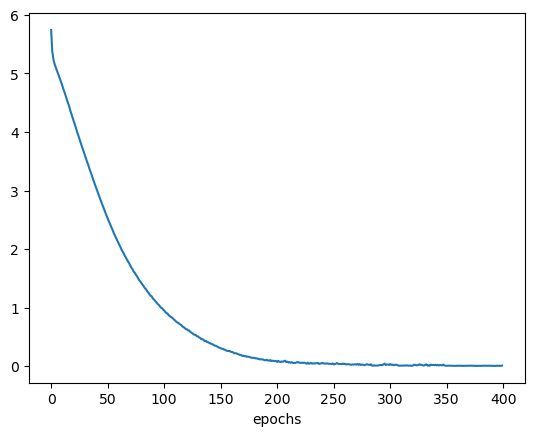

In [16]:
plt.plot(epoch_losses)
plt.xlabel("epochs")

In [17]:
# getting the word embeddings from the tained model
word_embeddings = model_cbow.embedding.weight.detach().cpu().numpy()

# example embedding of the word 'baller'
word = 'baller'
word_index = vocab.get_stoi()[word] # getting the index of the word from the vocab
word_embedding = word_embeddings[word_index]
print("Embedding for the word 'baller':-\n",word_embedding)
print("Embedding dimention:- ", word_embedding.size)

Embedding for the word 'baller':-
 [ 0.4600549  -0.19819209 -0.56013024 -1.0970945   0.6358268   0.49584427
  0.178115    0.07506974 -0.00173575 -0.9578417  -0.38137838  1.3308636
  0.20835382 -0.14537755 -0.14939971 -0.6938544  -0.09692334  1.1975751
 -0.2984106  -0.8782528  -0.91873014 -0.31597757 -0.38856956 -0.13338706]
Embedding dimention:-  24


##### Visualizing the word embeddings in 2d

  File "C:\Users\vijay\anaconda3\envs\IBM_CUDA\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\vijay\anaconda3\envs\IBM_CUDA\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\vijay\anaconda3\envs\IBM_CUDA\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\vijay\anaconda3\envs\IBM_CUDA\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


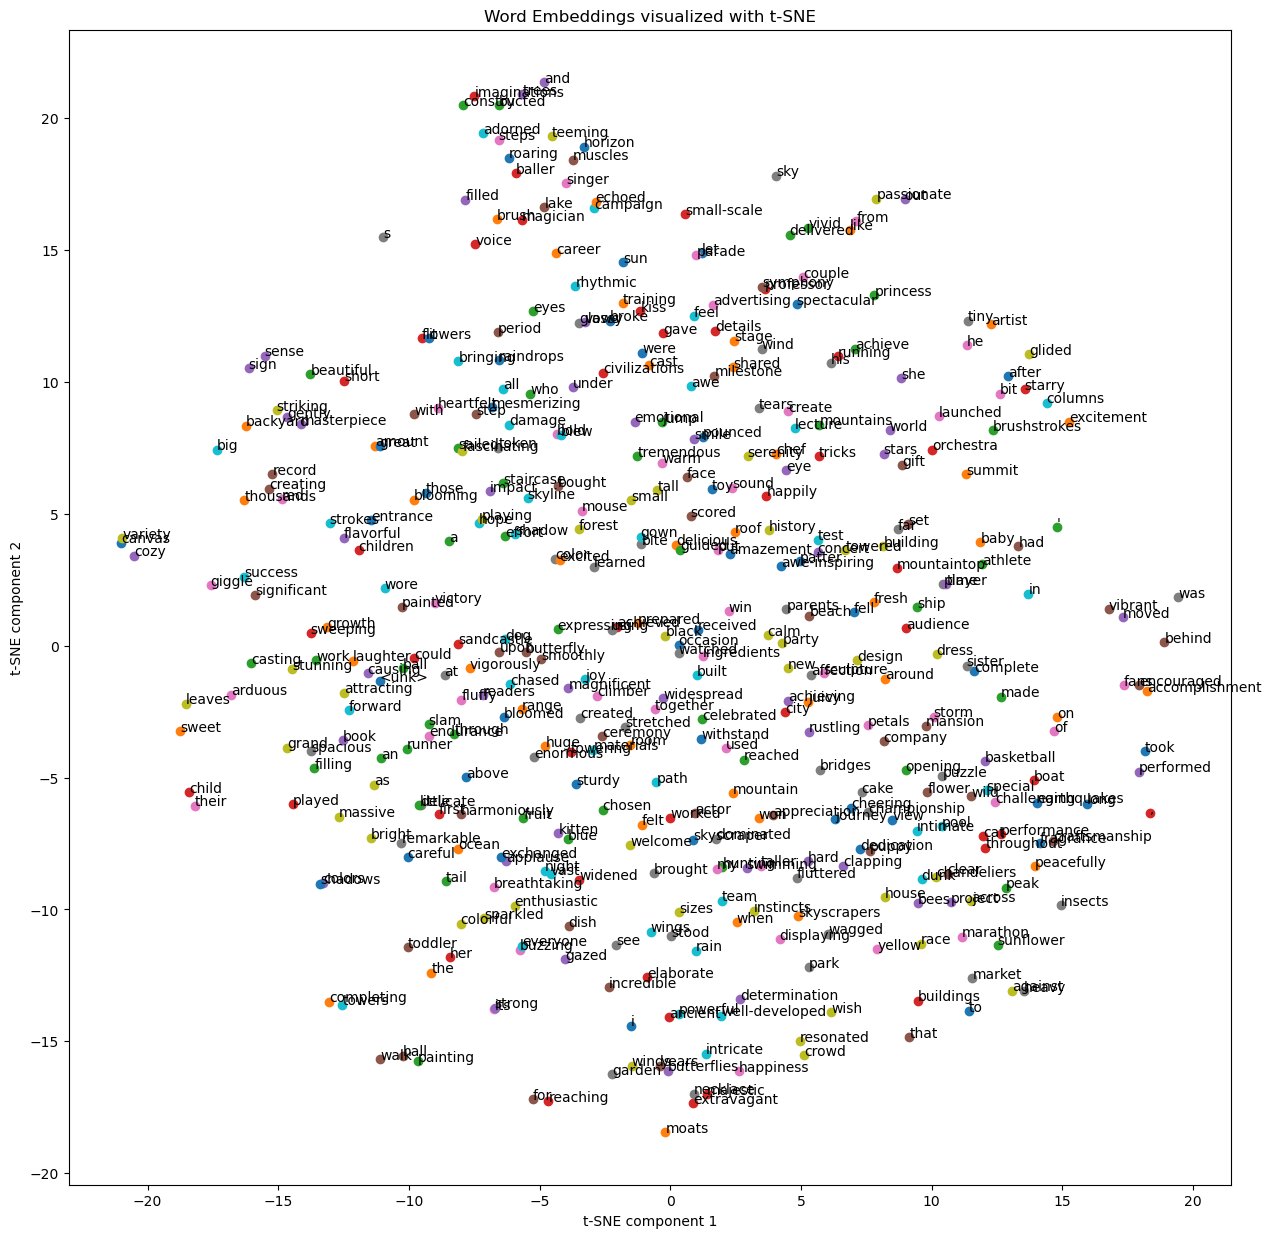

In [18]:
plot_embeddings(word_embeddings, vocab=vocab)

## Skip-Gram model

#### Pre-processing the data for training

In [19]:
# generating target and context traing data
CONTEXT_SIZE = 2
skip_data = []
for i in range(CONTEXT_SIZE, len(tokenized_toy_data)-CONTEXT_SIZE):
    context = (
        [tokenized_toy_data[i-j-1] for j in range(CONTEXT_SIZE)] +
        [tokenized_toy_data[i+j+1] for j in range(CONTEXT_SIZE)]
    )
    target = tokenized_toy_data[i]
    skip_data.append((target, context))

# windowing the skip_data
skip_data_=[[(sample[0],word) for word in  sample[1]] for sample in skip_data]
skip_data_flat= [item  for items in  skip_data_ for item in items]

print("First 5 words from the training data: ->", ' '.join(tokenized_toy_data[:5]))
print("\nExample trining data:-                 ","[('Traget', 'context'),.............('Traget', 'context')]")
print(f"                                        {skip_data_flat[0:4]}")
print("\nToken Indices :-                       ", [(vocab[t],vocab[c]) for t,c in skip_data_flat[0:4]])


First 5 words from the training data: -> i wish i was little

Example trining data:-                  [('Traget', 'context'),.............('Traget', 'context')]
                                        [('i', 'wish'), ('i', 'i'), ('i', 'was'), ('i', 'little')]

Token Indices :-                        [(20, 108), (20, 20), (20, 7), (20, 272)]


In [20]:
# a function to convert the pre-processed data into tensors for each "batch" from the "dataloader"
def collate_fn(batch):
    target_list, context_list = [], []
    for _context, _target in batch:
        target_list.append(vocab[_target])
        context_list.append(vocab[_context])

    target_list_tensor = torch.tensor(target_list, dtype=torch.int64)
    context_list_tensor = torch.tensor(context_list, dtype=torch.int64)
    return target_list_tensor.to(device), context_list_tensor.to(device)

#### Creating dataloaders for ML model

In [21]:
# creating dataloaders using "DataLoader" function from "pytorch" library
dataloader_skip = DataLoader(
    skip_data_flat,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn
)

# Processing the first traning batch from the DataLoader
target_tensor, context_tensor = next(iter(dataloader_skip))
print("The first batch of the traning DataLoader-")
print("\n\ncontext_tensor:-\n", context_tensor)
print("\n\ntarget_tensor:-\n", target_tensor)

The first batch of the traning DataLoader-


context_tensor:-
 tensor([ 20,  20,  20,  20,   7,   7,   7,   7, 272, 272, 272, 272, 136, 136,
        136, 136, 376, 376, 376, 376,  20,  20,  20,  20, 108, 108, 108, 108,
         20,  20,  20,  20,   7,   7,   7,   7,   2,   2,   2,   2, 133, 133,
        133, 133,  14,  14,  14,  14, 109, 109, 109, 109,   2,   2,   2,   2,
          8,   8,   8,   8, 138, 138, 138, 138], device='cuda:0')


target_tensor:-
 tensor([108,  20,   7, 272,  20, 108, 272, 136,   7,  20, 136, 376, 272,   7,
        376,  20, 136, 272,  20, 108, 376, 136, 108,  20,  20, 376,  20,   7,
        108,  20,   7,   2,  20, 108,   2, 133,   7,  20, 133,  14,   2,   7,
         14, 109, 133,   2, 109,   2,  14, 133,   2,   8, 109,  14,   8, 138,
          2, 109, 138, 198,   8,   2, 198,  10], device='cuda:0')


#### Skip-Gram model architecture

In [22]:
#a feed forward NN implemented using "nn.EmbeddingBag", "nn.Linear" functions from "pytorch" library
class SkipGram_Model(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(SkipGram_Model, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, text):
        out = self.embeddings(text)
        out = torch.relu(out)
        out = self.fc(out)

        return out

In [23]:
# instantiating the model
emsize = 24
model_sg = SkipGram_Model(vocab_size, emsize).to(device)

#### Example of one forward pass

In [24]:
# getting the embedding of the training text token indices for the 64 documents in the batch
context_embedding = model_sg.embeddings(context_tensor)
# passing the embeddings through the relu activation function
relu_out = torch.relu(context_embedding)
# passing through the fully connected final layer 
nn_out = model_sg.fc(relu_out)

print("One example forward pass through the first four example of the first batch of the traning DataLoader-\n")
print("\ncontext_tensor:-\n", context_tensor[:4])
print("\ncontext_embeddings:-\n",context_embedding[:4])
print("\nrelu_out:-\n", relu_out[:4])
print("\nnn_out:-\n", nn_out[:4])
print("\ntarget_tensor:-\n", target_tensor[:4])

One example forward pass through the first four example of the first batch of the traning DataLoader-


context_tensor:-
 tensor([20, 20, 20, 20], device='cuda:0')

context_embeddings:-
 tensor([[ 0.9013,  0.1053,  0.2406, -0.8159,  1.4543,  0.1468, -0.8018, -0.5351,
          1.0867,  1.0727,  0.4391, -1.0809, -0.0887, -0.3480,  1.2632, -2.0635,
          0.0397, -1.3003,  0.2733, -1.3986, -1.0202,  1.6680,  0.2792,  0.0441],
        [ 0.9013,  0.1053,  0.2406, -0.8159,  1.4543,  0.1468, -0.8018, -0.5351,
          1.0867,  1.0727,  0.4391, -1.0809, -0.0887, -0.3480,  1.2632, -2.0635,
          0.0397, -1.3003,  0.2733, -1.3986, -1.0202,  1.6680,  0.2792,  0.0441],
        [ 0.9013,  0.1053,  0.2406, -0.8159,  1.4543,  0.1468, -0.8018, -0.5351,
          1.0867,  1.0727,  0.4391, -1.0809, -0.0887, -0.3480,  1.2632, -2.0635,
          0.0397, -1.3003,  0.2733, -1.3986, -1.0202,  1.6680,  0.2792,  0.0441],
        [ 0.9013,  0.1053,  0.2406, -0.8159,  1.4543,  0.1468, -0.8018, -0.5351,


#### NN Training

In [25]:
# defining the learning rate, loss criterion, optimizer and learning rate scheduler using functions from the PyTorch Library
LR = 5 # learning rate
criterion = torch.nn.CrossEntropyLoss() # loss criterion 
optimizer = torch.optim.SGD(model_sg.parameters(), lr=LR) # optimizer 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma=0.1) #learning rate scheduler

In [26]:
# training the Skip-Gram model
model_sg, epoch_losses=train_model(model_sg, dataloader_skip, criterion, optimizer, num_epochs=400)

100%|██████████| 400/400 [00:24<00:00, 16.05it/s]


In [27]:
#### Plotting the loss values over the course of training

Text(0.5, 0, 'epochs')

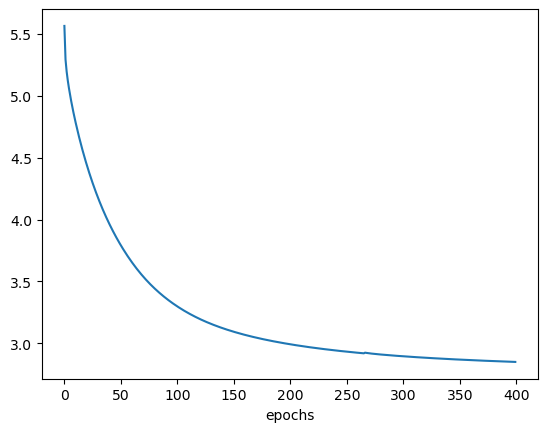

In [28]:
plt.plot(epoch_losses)
plt.xlabel("epochs")

#### Visualizing the word embeddings in 2d

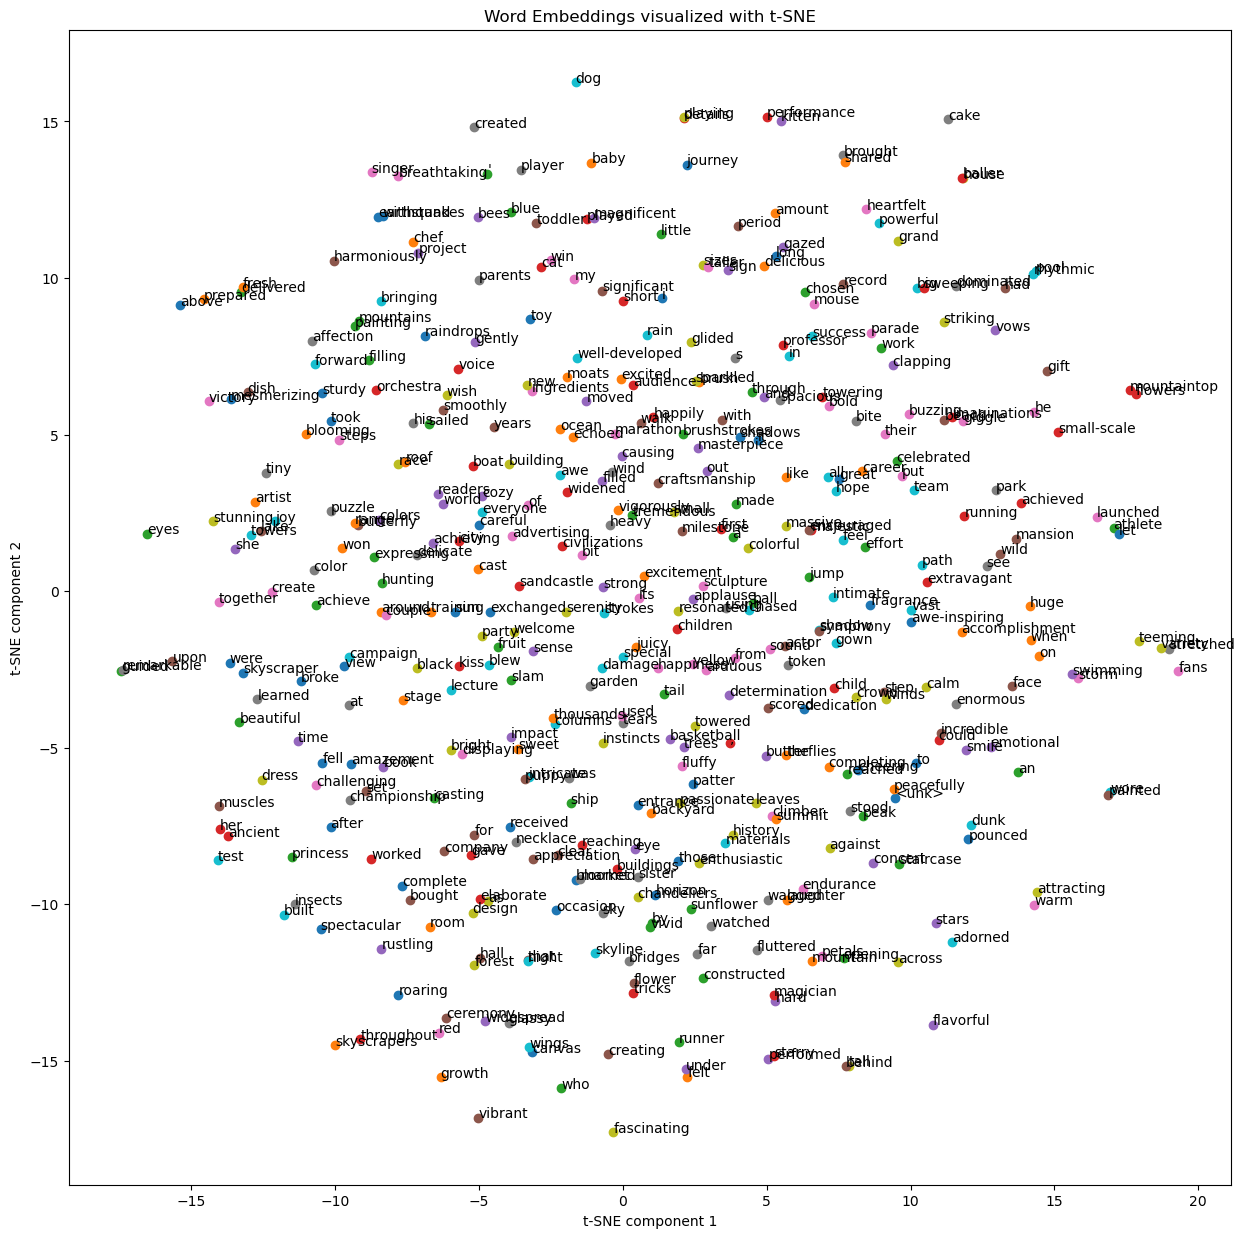

In [32]:
# getting the word embeddings from the tained model
word_embeddings = model_sg.embeddings.weight.detach().cpu().numpy()
plot_embeddings(word_embeddings, vocab=vocab)